In [4]:
import sys

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

sys.path.append('../src')
import columnar as col

%load_ext autoreload
%autoreload 2

# Categorical Embeddings
Alternative to General

In [6]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
df = col.loaders.petfinder._load('../')
feature_selection = col.FeatureSelection(**col.loaders.petfinder._select_features(df))

In [ ]:
df.target.mean()

In [ ]:
{col: df[col].nunique() for col in df.columns}

In [13]:
ds = col.embeddings.data.df_to_dataset(df, 'target', batch_size=32)

[autoreload of columnar.embeddings.wrapper failed: Traceback (most recent call last):
  File "/Users/spayot/miniforge3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/spayot/miniforge3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/spayot/miniforge3/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/spayot/miniforge3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/spayot/projects/mtePlus/notebooks/../src/columnar/embeddings/wrapper.py", line 16, in <module>
    from .data import df_to_dataset
ModuleNot

AttributeError: module 'columnar.embeddings' has no attribute 'data'

In [12]:
from sklearn.ensemble import RandomForestClassifier

feats = col.feature_selection.FeatureSelection(target='target',categoricals=['type'], numericals=['photoamt', 'videoamt', 'fee', 'age'])
transformer = col.encoder.MeanTargetEncoder(feats)
model = RandomForestClassifier(n_estimators=100, max_depth=5)
pipe = col.model.CategoricalPipeline(features=feats,
                                     transformer=transformer,
                                     scaler=None,
                                     model=model,
                                    )

In [37]:
from sklearn.metrics import accuracy_score, f1_score

pipe = col.CategoricalPipeline(features=feature_selection,
                              transformer=col.MeanTargetEncoder(feats),
                              model=RandomForestClassifier(max_depth=5, n_estimators=100))

pipe.fit(df)
print(pipe.predict(df.head()))
f1_score(df.target, (pipe.predict(df) > .5))

[0.72730883 0.83452213 0.86059307 0.66455585 0.81519586]


0.8396311555817147

In [43]:
# test behavior of 
col.FeatureSelection()

{'categories': 'auto',
 'drop': None,
 'dtype': numpy.float64,
 'handle_unknown': 'error',
 'sparse': True}

In [44]:
[(train_features, label_batch)] = ds.take(1)

feature_selection = col.FeatureSelection(categoricals=['type', 'age', 'breed1', 'breed2', 'gender', 'color1', 'color2', 'color3', 'maturitysize', 'furlength', 'vaccinated', 'dewormed', 'sterilized', 'health', 'quantity', 'state', 'rescuerid', 'has_name'], 
                                         numericals=['photoamt', 'videoamt', 'fee'], 
                                         target='target')

In [9]:
df2, labels = df.drop(columns=['target']), df.target

In [40]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(df)

OneHotEncoder()

In [42]:
{col: (len([f for f in ohe.get_feature_names_out() if col in f]), df[col].nunique()) for col in df.columns}

{'type': (2, 2),
 'age': (106, 106),
 'breed1': (176, 176),
 'breed2': (135, 135),
 'gender': (3, 3),
 'color1': (7, 7),
 'color2': (7, 7),
 'color3': (6, 6),
 'maturitysize': (4, 4),
 'furlength': (3, 3),
 'vaccinated': (3, 3),
 'dewormed': (3, 3),
 'sterilized': (3, 3),
 'health': (3, 3),
 'quantity': (19, 19),
 'fee': (117, 74),
 'state': (14, 14),
 'rescuerid': (5595, 5595),
 'videoamt': (9, 9),
 'photoamt': (31, 31),
 'has_name': (2, 2),
 'target': (2, 2)}

In [ ]:
col.embeddings.TFCatEmbeddingEncoder(features=feature_selection, )

In [12]:


base_factory = {name: col.embeddings.TFEmbeddingLayer for name in feature_selection.categoricals}
base_factory.update({name: col.embeddings.TFNormalizationLayer for name in feature_selection.numericals})
print(base_factory)


{'type': <class 'columnar.embeddings.tf_preprocessing.TFEmbeddingLayer'>, 'breed1': <class 'columnar.embeddings.tf_preprocessing.TFEmbeddingLayer'>, 'breed2': <class 'columnar.embeddings.tf_preprocessing.TFEmbeddingLayer'>, 'gender': <class 'columnar.embeddings.tf_preprocessing.TFEmbeddingLayer'>, 'color1': <class 'columnar.embeddings.tf_preprocessing.TFEmbeddingLayer'>, 'color2': <class 'columnar.embeddings.tf_preprocessing.TFEmbeddingLayer'>, 'color3': <class 'columnar.embeddings.tf_preprocessing.TFEmbeddingLayer'>, 'maturitysize': <class 'columnar.embeddings.tf_preprocessing.TFEmbeddingLayer'>, 'furlength': <class 'columnar.embeddings.tf_preprocessing.TFEmbeddingLayer'>, 'vaccinated': <class 'columnar.embeddings.tf_preprocessing.TFEmbeddingLayer'>, 'dewormed': <class 'columnar.embeddings.tf_preprocessing.TFEmbeddingLayer'>, 'sterilized': <class 'columnar.embeddings.tf_preprocessing.TFEmbeddingLayer'>, 'health': <class 'columnar.embeddings.tf_preprocessing.TFEmbeddingLayer'>, 'quanti

In [29]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=.2)

ds_train = col.embeddings.df_to_dataset(df_train, 'target', batch_size=32)
ds_test = col.embeddings.df_to_dataset(df_test, 'target', batch_size=32)

model = col.embeddings.TFCatEmbsClassifier(ds_train, feature_selection)
# model(train_features)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

# model.fit(ds_train, epochs=3, val)
# model.evaluate(ds_test)

2022-02-01 11:48:45.747895: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-01 11:48:45.777947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-01 11:48:46.222878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-01 11:48:46.616763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-01 11:48:47.009810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-01 11:48:47.404302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-01 11:48:47.804047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112

In [51]:
hist = model.fit(ds_train, epochs=5, validation_data=ds_test, verbose=2)

Epoch 1/5
375/375 - 21s - loss: 0.1889 - accuracy: 0.9100 - val_loss: 0.5766 - val_accuracy: 0.7699 - 21s/epoch - 57ms/step
Epoch 2/5
375/375 - 21s - loss: 0.1802 - accuracy: 0.9093 - val_loss: 0.6010 - val_accuracy: 0.7546 - 21s/epoch - 56ms/step
Epoch 3/5
375/375 - 21s - loss: 0.1767 - accuracy: 0.9121 - val_loss: 0.6131 - val_accuracy: 0.7472 - 21s/epoch - 57ms/step
Epoch 4/5
375/375 - 21s - loss: 0.1697 - accuracy: 0.9119 - val_loss: 0.6375 - val_accuracy: 0.7609 - 21s/epoch - 56ms/step
Epoch 5/5
375/375 - 21s - loss: 0.1669 - accuracy: 0.9118 - val_loss: 0.6576 - val_accuracy: 0.7543 - 21s/epoch - 57ms/step


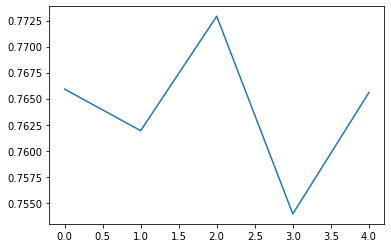

In [41]:
plt.plot(hist.history.get('val_accuracy'))

In [57]:
a = model.predict(ds_test)
a.shape, type(a)

((2999, 1), numpy.ndarray)

In [143]:
X = np.random.randn(1000,4)
y = X[:,0] + np.random.randn(1000) / 5

inp = tf.keras.layers.Input(shape=(4,))
x = tf.keras.layers.Dense(2)(inp)
a = tf.keras.models.Model(inp, x)

out = tf.keras.layers.Dense(1)(a(inp))

m = tf.keras.models.Model(inp, out)
m.compile(optimizer='adam', loss='mean_squared_error')
hist = m.fit(X, y, epochs=20, verbose=0, batch_size=5)
m.evaluate(X, y)

2022-02-01 20:01:56.874997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step - loss: 0.0408


2022-02-01 20:02:06.064416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.0407966785132885

In [148]:
col.embeddings.TFCatEmbeddingEncoder

[autoreload of columnar.embeddings failed: Traceback (most recent call last):
  File "/Users/spayot/miniforge3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/spayot/miniforge3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/spayot/miniforge3/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/spayot/miniforge3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/spayot/projects/mtePlus/notebooks/../src/columnar/embeddings/__init__.py", line 4, in <module>
    from .tf_models import TFCatEmbsModel, TFCatEmbed

AttributeError: module 'columnar.embeddings' has no attribute 'TFCatEmbeddingEncoder'

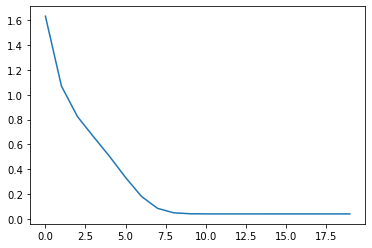

In [144]:
plt.plot(hist.history.get('loss'))

In [147]:
np.matmul(m.get_weights()[0], m.get_weights()[2]).round(2)

array([[ 0.99],
       [-0.01],
       [-0.01],
       [ 0.02]], dtype=float32)

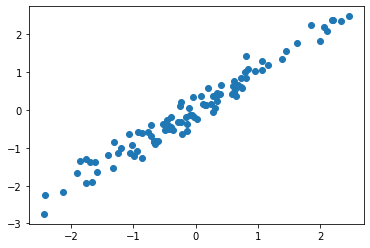

In [130]:
plt.scatter(X[:,0], y)

In [50]:
loss, acc = model.fit()

Signature:
model.fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose='auto',
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)
Docstring:
Trains the model for a fixed number of epochs (iterations on a dataset).

Args:
    x: Input data. It could be:
      - A Numpy array (or array-like), or a list of arrays
        (in case the model has multiple inputs).
      - A TensorFlow tensor, or a list of tensors
        (in case the model has multiple inputs).
      - A dict mapping input names to the corresponding array/tensors,
        if the model has named inputs.
      - A `tf.data` dataset. Should return a tuple
        of either `(inputs, targets)` or
        `(inputs, targets, sam

In [ ]:
loss, acc = model.fit